## Model Pipeline
**Data preprocessing**: Resize to 224x224, no filter

**Model**: ViT B16 Model from Google [paper](https://arxiv.org/abs/2010.11929)
using Keras implementation from faustomorales [GitHub](https://github.com/faustomorales/vit-keras)

In [1]:
# !pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
tf.__version__

'2.3.4'

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:2', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:3', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

### Load the data
Dataset must have the following columns: 
- **waferMap**: defect data of wafer map where 0 = blank spot, 1 = normal die (passed the electrical test), and 2 = broken die (failed electrical test)
- **ID**: unique identification for each waferMap, separate from dataframe index

If labeled, dataset must have the following columns:
- **detectLabels**: for evaluating the detect model, where 0 = no defect, 1 = defect
- **classifyLabels**: for evaluating the classify model, where 0 = Loc, 1 = Edge-Loc, 2 = Center, 3 = Edge-Ring, 4 = Scratch, 5 = Random, 6 = Near-full, 7 = Donut, 8 = none

In [5]:
# specify variables

# specify data to load
path = 'processed_data/customer'
filename = 'MixedWM38-single'
labeled = True

# where to save results
result_path = ''
result_filename = ''

# which models to run
classify_model = 'vit-b16-224-undersampled.h5'

In [6]:
# load data directly from S3 (using boto3 resource)
start = time.time()

data_key = f'{path}/{filename}.pkl'
data = pickle.loads(my_bucket.Object(data_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Dataset length: {len(data)}")

Wall time: 0.43 seconds
Dataset length: 8015


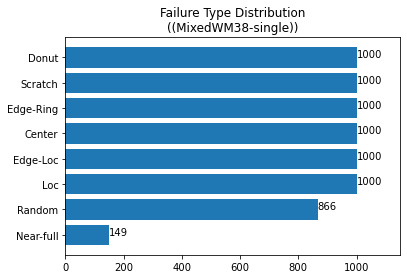

In [7]:
# IF LABELED
# show failure type distribution
if labeled:
    data_defects = data[data.detectLabels == 1]
    helper.defect_distribution(data_defects, note=f'({filename})')

### Data preprocessing

In [8]:
# resize to 224x224
start = time.time()

def preprocess(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    return new_y
    
data['waferMap224'] = data.waferMap.apply(lambda x: preprocess(x))

print("Wall time: {:.2f} seconds".format(time.time() - start))
print("Sanity checks:")
print(f'Map shape: {data.waferMap224[0].shape}')
print(f'Map unique values:{np.unique(data.waferMap224[0])}')

Wall time: 21.79 seconds
Sanity checks:
Map shape: (224, 224)
Map unique values:[0 1 2]


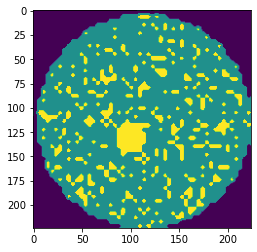

In [10]:
plt.imshow(data.waferMap224[0])

### Classify Model

##### Data set-up

In [11]:
# prepare inputs
start = time.time()

x_cls = np.stack(data['waferMap224'])
x_cls = tf.expand_dims(x_cls, axis=3, name=None)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_cls.shape

Wall time: 3.43 seconds


TensorShape([8015, 224, 224, 1])

In [12]:
# IF LABELED
# prepare labels for evaluating results
if labeled:
    y_cls = np.asarray(data['classifyLabels']).astype(np.uint8)

##### Load and run classify model

In [13]:
# load saved classify model from S3
start = time.time()

classify = models.load_model(classify_model)
classify.summary()

print("Wall time: {:.2f} seconds".format(time.time() - start))

ValueError: Unknown layer: Custom>ClassToken

In [ ]:
# generate predictions
start = time.time()

classify_pred = classify.predict(x_cls)
cls_labels = np.argmax(classify_pred, axis=1).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))

### Collect tandem model results
Saved predictions include 2 lists:
- Output of classify model (softmax probabilities)
- Labels predicted by classify model

In [ ]:
# # save predictions to local instance
# predictions = [classify_pred, cls_labels]
# with open(f'{result_path}/{result_filename}.pkl', "wb") as f:
#     pickle.dump(predictions, f)

In [ ]:
# IF LABELED
if labeled: 
    y_test = data['classifyLabels'].tolist()
    
    # manually compute overall accuracy
    cls_cm = confusion_matrix(y_test, cls_labels)

    cls_num = 0
    for i in range(9):
        cls_num += cls_cm[i][i]

    overall_accuracy = cls_num / len(y_test) * 100
    print(f'Overall Model Accuracy: {overall_accuracy:.2f}%') 

    # plot confusion matrix
    helper.plot_confusion_matrix(y_test, cls_labels, mode='all', normalize=True)

In [ ]:
# IF LABELED
# plot confusion matrix counts
if labeled:
    helper.plot_confusion_matrix(y_test, cls_labels, mode='all', normalize=False)